In [ ]:
Group 20 members:
- Janick Michot:          michojan@students.zhaw.ch
- Andre von Aarburg :     andre.vonaarbrug@ost.ch
- Manuel Weiss:           weissman@students.zhaw.ch

In [2]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
import matplotlib.pyplot as plt

### Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [3]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

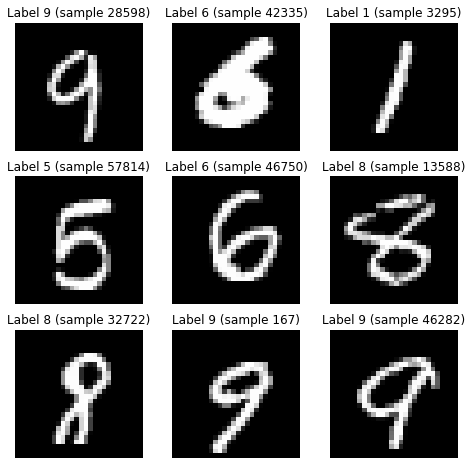

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

#### Data Loader (see lecture)

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [7]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


torch.Size([1, 28, 28])
torch.Size([28, 28])


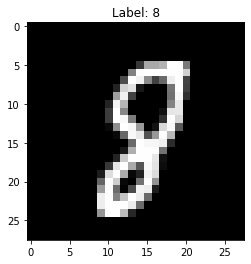

In [8]:

img = data_train[0]
print(img.shape)

# As you can see squeeze removes the unnecessary dimensions of size 1
# -> the single channel img of shape (1, 28, 28) gets reduced to (28, 28)
img = img.squeeze()

print(img.shape)
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [9]:
import torch.nn as nn
def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)

    nb = x.shape[0]
    x1 = x.view(nb, -1) # flatten

    return x1@W.T+b
    
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    s = torch.exp(z)
    s_exp_sum = torch.sum(s, dim=1, keepdim=True)
    return s/s_exp_sum
    
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    return softmax(linear_trsf(x, W, b))
    # YOUR CODE (END)


In [101]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
X0 = torch.stack([x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x], dim=0)
u = predict(X0, W, b)

t = torch.sum(u)
t_single = torch.sum(u[0,:])




nb = X0.shape[0]

x1 = X0.view(nb, -1)


l = x1@W.T+b

print(u.shape)



x1 shape torch.Size([64, 784])
W shape torch.Size([10, 784])
W.T shape torch.Size([784, 10])
torch.Size([64, 10])


##### TEST

In [25]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape,b.shape)
u = predict(x,W,b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 1.0


#### Loss Function

In [45]:
def loss_ce(_y, _uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
    nb = _y.shape[0]

    return -torch.log(_uhat[torch.arange(nb), _y[:]])


    # YOUR CODE (END)

def cost_ce(_y,_uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    return torch.mean(loss_ce(_y, _uhat))
    
    # YOUR CODE (END)


##### TEST

In [32]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2, 3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))



tensor([2.4076, 1.0986]) tensor(1.7531)


### Gradient Descent for the given Model

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [44]:
def grad_loss_ce(x,u,uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)

    gradW = torch.mean((uhat-u).view(-1, 10, 1)*x.view(-1, 1, 28*28), dim=0)
    gradb = torch.mean((uhat-u), dim=0)
    return gradW, gradb
    
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy.

In [ ]:
def get_u(Y, classcount):
    return (Y.view(-1, 1) == torch.arange(classcount).view(1, classcount)).float()

In [12]:
def metrics(_X,_Y,_W,_b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)

    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)
    _nb = _X.shape[0]
    _uhat = predict(_X, _W, _b)
    _cce = cost_ce(_Y, _uhat)
    _acc = torch.sum((_Y == torch.argmax(_uhat, dim=1))).float() / _nb

    return _cce.item(), _acc.item()


    # YOUR CODE (END)

In [51]:
nepochs = 10
alpha = 0.01
nclasses = 10
nbatch = 10

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

nn_cost_ce = torch.nn.CrossEntropyLoss()

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)

# test data - we can load all samples for the test since it easily fits into memory
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True)))

# initial parameters
W,b = torch.randn((10,28*28)), torch.zeros((1,10))

d0 = datetime.now()

size = len(train_dataloader.dataset)
num_batches = len(train_dataloader)

for epoch in range(nepochs):
    cost = 0.0
    acc = 0
    for X,Y in train_dataloader:
        uhat = predict(X, W, b)

        cost += nn_cost_ce(uhat, Y).item()
        acc += (Y == uhat.argmax(dim = 1)).type(torch.float).sum().item()

        u = (Y.view(-1, 1) == torch.arange(nclasses).view(1, nclasses)).float()

        gradW, gradb = grad_loss_ce(X, u, uhat)
        W = W - alpha * gradW
        b = b - alpha * gradb

    cost /= num_batches
    cost_hist.append(cost)

    acc /= size
    acc_hist.append(acc)
    cce_test, acc_test = metrics(Xtest, Ytest, W, b)
    acc_hist_test.append(acc_test)
    cost_hist_test.append(cce_test)

    print("Epoch %i: cost %f, cost_test %f, acc %f, acc_test %f"%(epoch, cost, cce_test, acc, acc_test))

d = datetime.now()
print((d-d0).total_seconds()/nepochs)

Epoch 0: cost 1.885265, cost_test 1.096310, acc 0.578467, acc_test 0.767000
Epoch 1: cost 1.680067, cost_test 0.804644, acc 0.791133, acc_test 0.824500
Epoch 2: cost 1.644505, cost_test 0.695687, acc 0.828250, acc_test 0.843800
Epoch 3: cost 1.628044, cost_test 0.634306, acc 0.845350, acc_test 0.855900
Epoch 4: cost 1.618353, cost_test 0.591840, acc 0.855067, acc_test 0.865100
Epoch 5: cost 1.611571, cost_test 0.561386, acc 0.862650, acc_test 0.870300
Epoch 6: cost 1.606682, cost_test 0.538688, acc 0.868533, acc_test 0.873300
Epoch 7: cost 1.603244, cost_test 0.518782, acc 0.872533, acc_test 0.876600
Epoch 8: cost 1.599938, cost_test 0.504458, acc 0.876650, acc_test 0.879000
Epoch 9: cost 1.597280, cost_test 0.490679, acc 0.879700, acc_test 0.882900
7.8622457


Text(0.5, 1.0, 'Accuracy')

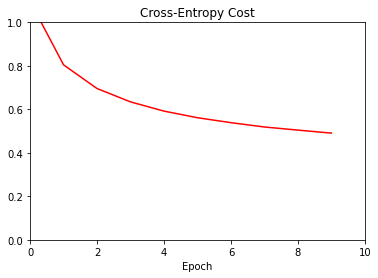

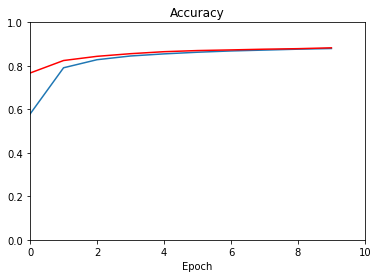

In [52]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.0, 1)
plt.title("Accuracy")

### Mini-Batch Gradient Descent

Text(0.5, 1.0, 'Accuracy')

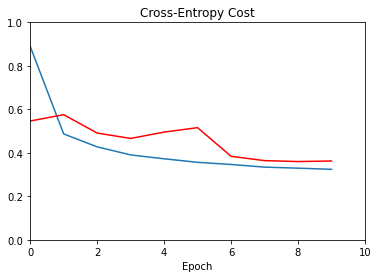

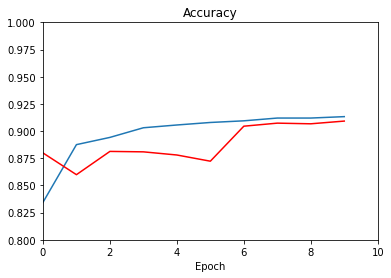

In [18]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

### With Full-Fledge PyTorch

In [38]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten(start_dim=1, end_dim=-1)
        self.linear  = torch.nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, _x): # use just one linear layer and pytorch's CrossEntropyLoss
        _z = self.linear(self.flatten(_x))
        return _z


In [39]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [40]:
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [41]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

nn_cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        loss = nn_cost_ce(pred, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cost += loss.item()
        acc += (Y == pred.argmax(dim = 1)).type(torch.float).sum().item()

    cost /= nbatches
    acc /= size
    acc_test = 0.0
    cost_test = 0.0
    with torch.no_grad():
        for X, Y in test_loader:
            pred_test = model(X)
            _cce = nn_cost_ce(pred_test, Y)
            _acc = (pred_test.argmax(dim=1) == Y).type(torch.float).sum().item() / X.shape[0]
            acc_test += _acc
            cost_test += _cce
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.978833, 0.799733, 0.600803, 0.869800
Epoch 1: 0.550818, 0.867900, 0.475515, 0.882700
Epoch 2: 0.471218, 0.879650, 0.426023, 0.893000
Epoch 3: 0.432509, 0.886517, 0.397459, 0.897100


KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy')

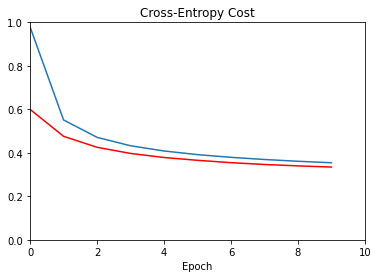

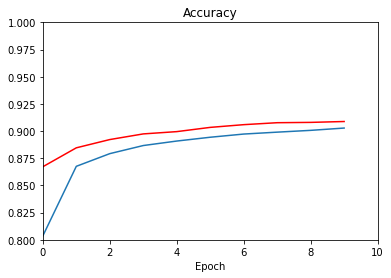

In [23]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

In [36]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        loss = torch.nn.CrossEntropyLoss()

        output = loss(pred, Y)
        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
    cost /= nbatches
    acc /= size
    acc_test = 0.0
    cost_test = 0.0
    with torch.no_grad():
        for Xtest, Ytest in test_loader:
            pred_test = model(Xtest)
            _cce = cost_ce(Ytest, pred_test)
            _acc = torch.sum((Ytest == torch.argmax(pred, dim=1))).float() / Xtest.shape[0]
            acc_test += _acc
            cost_test += _cce
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.983347, 0.798517, 0.603200, 0.867500
Epoch 1: 0.552474, 0.867283, 0.477130, 0.884000
Epoch 2: 0.472336, 0.879833, 0.426591, 0.891300
Epoch 3: 0.433343, 0.886117, 0.398831, 0.896200
Epoch 4: 0.408873, 0.891000, 0.381611, 0.899200
Epoch 5: 0.392192, 0.894483, 0.364884, 0.902000
Epoch 6: 0.379480, 0.897100, 0.355054, 0.905300
Epoch 7: 0.369738, 0.899250, 0.345773, 0.906000
Epoch 8: 0.361385, 0.900750, 0.340056, 0.907500
Epoch 9: 0.354670, 0.902517, 0.333860, 0.907700


Text(0.5, 1.0, 'Accuracy')

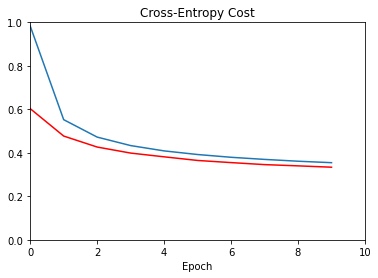

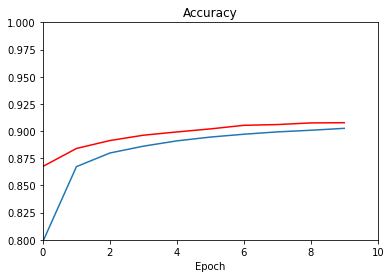

In [37]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

### Analysis of different settings for learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Can you explain the behavior?